In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from skactiveml.pool import GreedySamplingX
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tqdm as tqdm
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from scipy import stats


#read in data
df = pd.read_csv('vegetation_data.csv')

#create x and y variables
y = df["N"]
y = y.to_numpy()

X = df.drop(["N_level", "N","POINTID"], axis=1)
T = df.drop(["N_level", "N","POINTID"], axis=1)

# Create a StandardScaler object
scaler = StandardScaler()
numeric_features = X.columns[:7]


# Standardize the first 7 features
X[numeric_features] = scaler.fit_transform(X[numeric_features])

X = X.to_numpy()

seed = 3


In [6]:
# creating some helper functions

#splitting data into train, pool, and test
def split_data(X,y,n_init, seed=seed):
    """splits the data into train,pool and test split with a pre-defined train size n_init."""

    n = len(y)


    X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_init / n, random_state=seed)
    X_pool, X_test, y_pool, y_test = train_test_split(X_pool, y_pool, test_size=0.3, random_state=seed)
    return dict(
        train = dict(
            X=X_train,
            y=y_train
        ),
        pool = dict(
            X=X_pool,
            y=y_pool
        ),
        test = dict(
            X=X_test,
            y=y_test
        )
    )

# function to update the train and pool data
def update_data(data, idx):
    
    """Update of the data dictionary from `prepare_data` by moving the data
    point with index `idx` from the pool to the training set."""
    data['train']['X'] = np.append(data['train']['X'], np.atleast_2d(data['pool']['X'][idx]), axis=0)
    data['train']['y'] = np.append(data['train']['y'], np.atleast_1d(data['pool']['y'][idx]), axis=0)    
    data['pool']['X'] = np.delete(data['pool']['X'], idx, axis=0)
    data['pool']['y'] = np.delete(data['pool']['y'], idx, axis=0)



def calculate_uncertainty(model, X_pool):
   
    # Get the predictions from each tree in the forest
    predictions = np.array([tree.predict(X_pool) for tree in model.estimators_])
    # Calculate the variance of the predictions
    uncertainties = np.std(predictions, axis=0)
    
    return uncertainties 



#fix the fit model function
def fit_model( seed, strategy,query_strategy, n_init, n_iterations):
    """Run `n_iterations` of active learning or random sampling.
    RETURNS
    ----------
    scores : ndarray
        The score at each iteration.    
    """
    # Initialize
    data = split_data(X, y, n_init, seed)
    scores = np.zeros(n_iterations)
    model = RandomForestRegressor(random_state=seed, n_estimators=1000, max_depth=3, max_features=2,min_samples_leaf=20)

    # Do active learning for `n_iterations` by executing the steps listed above
    
    # solution::start
    for i in range(n_iterations):
        # 1. Fit the model
        model = model.fit(data['train']['X'], data['train']['y'])

        # 2. Evaluate model on pool
        #prob = model.predict_proba(data['pool']['X'])
        test_pred = model.predict(data['test']['X'])
        scores[i] = metrics.mean_squared_error(test_pred, data['test']['y'],squared=False)
        #scores[i] = model.score(data['test']['X'], data['test']['y'])

        # 3. Evaluate uncertainty on pool and query

        if i < n_iterations:
            if strategy == 'al':
                if query_strategy == 'greedy':
                    min_distances_input = np.min(pairwise_distances(data['pool']['X'], data['train']['X']), axis=1)
                    predicted_outputs = model.predict(data['pool']['X'])
                    min_distances_output = np.min(pairwise_distances(predicted_outputs.reshape(-1, 1), data['train']['y'].reshape(-1, 1)), axis=1)
                    combined_distances = min_distances_input * min_distances_output
                    idx = np.argmax(combined_distances)
                    sampled_greedy[j,i] = idx
                    #print("Selected index:", idx)
                elif query_strategy == 'variance':  
                    uncertainties = calculate_uncertainty(model, data['pool']['X'])
                    idx = np.argmax(uncertainties)
                    sampled_variance[j,i] = idx

            elif strategy == 'random':
                idx = np.random.choice(len(data['pool']['X']), size=1,replace=False)[0]
                sampled_rn[j,i] = idx
                
            update_data(data, idx)

    return scores

In [8]:
# Settings
n_init = 2
n_iterations = 11 - n_init
n_avg = 10

# Average `n_avg` fits
scores_variance = np.zeros((n_avg, n_iterations))
scores_greedy = np.zeros((n_avg, n_iterations))
scores_rn = np.zeros((n_avg, n_iterations))


sampled_variance = np.zeros((n_avg, n_iterations))
sampled_greedy = np.zeros((n_avg, n_iterations))
sampled_rn = np.zeros((n_avg, n_iterations))

j = 0

# run the active learning on the models
for i in tqdm.tqdm(range(n_avg)):
    seed = 3+i
    scores_variance[i] = fit_model(seed, "al","variance", n_init, n_iterations)
    scores_greedy[i] = fit_model(seed, "al","greedy", n_init, n_iterations)
    scores_rn[i] = fit_model(seed, "random",None, n_init, n_iterations)
    print(f'Iteration {i+1}/{n_avg} done')
    j += 1



 10%|█         | 1/10 [00:22<03:24, 22.73s/it]

Iteration 1/10 done


 20%|██        | 2/10 [00:48<03:16, 24.62s/it]

Iteration 2/10 done


 30%|███       | 3/10 [01:11<02:48, 24.00s/it]

Iteration 3/10 done


 40%|████      | 4/10 [01:33<02:17, 22.96s/it]

Iteration 4/10 done


 50%|█████     | 5/10 [01:54<01:52, 22.42s/it]

Iteration 5/10 done


 60%|██████    | 6/10 [02:18<01:30, 22.71s/it]

Iteration 6/10 done


 70%|███████   | 7/10 [02:42<01:10, 23.43s/it]

Iteration 7/10 done


 80%|████████  | 8/10 [03:05<00:46, 23.02s/it]

Iteration 8/10 done


 90%|█████████ | 9/10 [03:26<00:22, 22.47s/it]

Iteration 9/10 done


100%|██████████| 10/10 [03:47<00:00, 22.75s/it]

Iteration 10/10 done


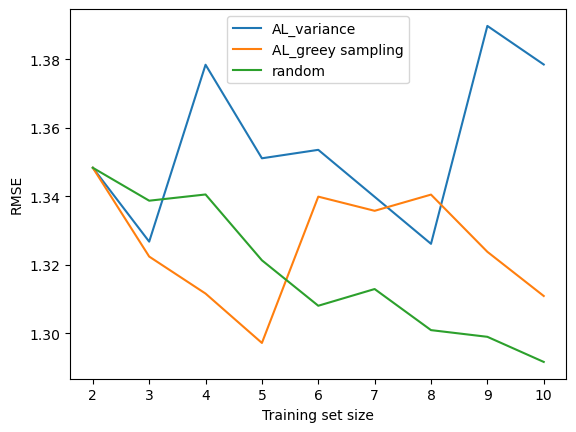

In [15]:
# Plot the results

fig, ax = plt.subplots(1, 1)
line1 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_variance.mean(0),label='AL_variance')
line2 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_greedy.mean(0),label='AL_greey sampling')
line3 = ax.plot(np.arange(n_init, n_iterations+n_init), scores_rn.mean(0),label='random')
ax.legend(handles=[line1[0], line2[0], line3[0]])
ax.set_xlabel('Training set size')
ax.set_ylabel('RMSE')
plt.show()

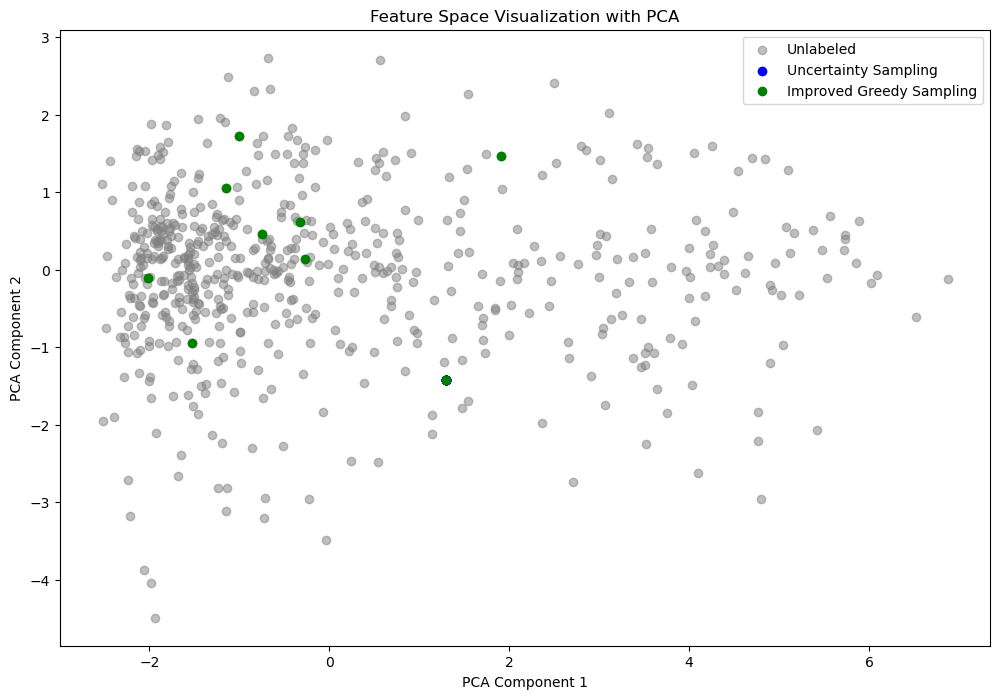

In [16]:
from sklearn.decomposition import PCA
from scipy import stats

i = 1

seed = 3+i
data = split_data(X, y, n_init, seed)
unlabeled_indices = data['pool']['X']

# PCA projection to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(unlabeled_indices)


z_scores = stats.zscore(X_pca)



X_pca = X_pca[(z_scores < 4).all(axis=1)]

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='gray', label='Unlabeled', alpha=0.5)
plt.scatter(X_pca[sampled_variance[0,::].astype(int), 0], X_pca[sampled_variance[0,::].astype(int), 1], c='blue', label='Uncertainty Sampling')
plt.scatter(X_pca[sampled_greedy[0,::].astype(int), 0], X_pca[sampled_greedy[0,::].astype(int), 1], c='green', label='Improved Greedy Sampling')

plt.legend()
plt.title('Feature Space Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [27]:
X_pca = PCA(n_components=5)
g_pca = PCA(n_components=5)

X_pca.fit(X)


components = X_pca.components_


components_df = pd.DataFrame(components, columns=T.columns, index=[f'PC{i+1}' for i in range(components.shape[0])])

# Define the greedy_indices variable as a 1-dimensional array
greedy_indices = sampled_greedy[0].astype(int)


X = pd.DataFrame(X, columns=T.columns)
# Use the greedy_indices to index the DataFrame
greedy_samples = X.iloc[greedy_indices]

g_pca.fit(greedy_samples)

greedy_components = g_pca.components_

greedy_components_df = pd.DataFrame(greedy_components, columns=T.columns, index=[f'PC{i+1}' for i in range(greedy_components.shape[0])])



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

components_df.loc['PC1'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Feature Importance for PC1')
ax[0].set_ylabel('Importance')
ax[0].set_xlabel('Features')
ax[0].tick_params(axis='x', rotation=90)

components_df.loc['PC2'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Feature Importance for PC2')
ax[1].set_ylabel('Importance')
ax[1].set_xlabel('Features')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


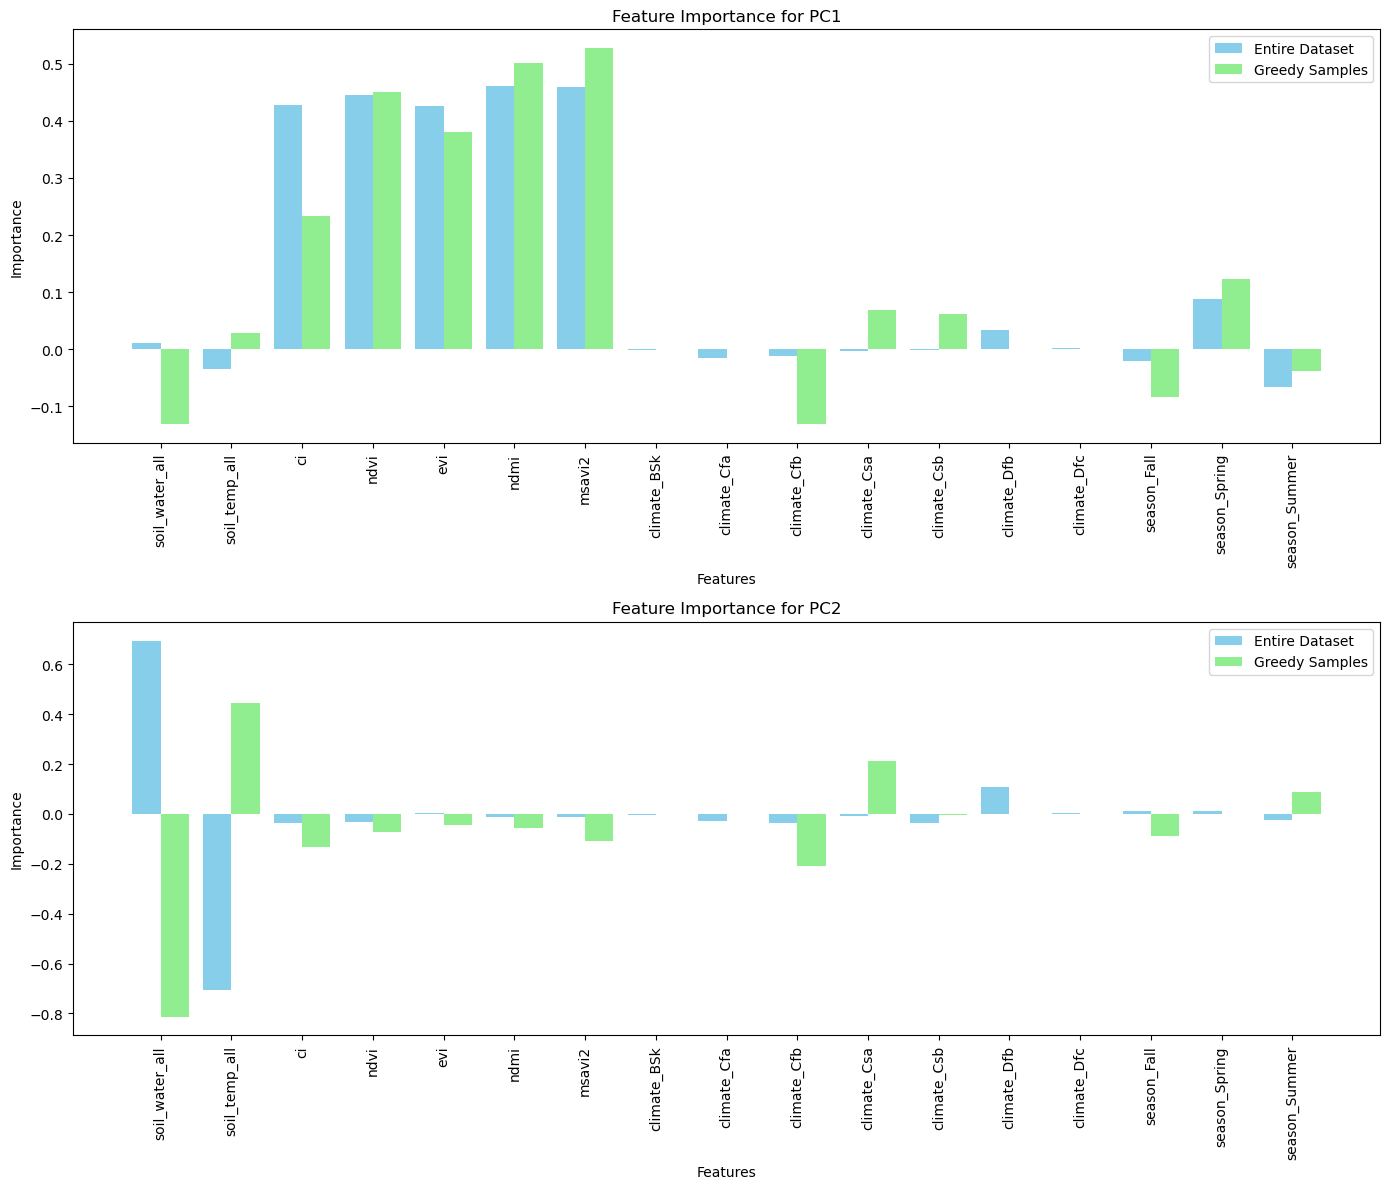

In [12]:
# Plot the feature importances for comparison
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plot for PC1
width = 0.4
x = np.arange(len(T.columns))

ax[0].bar(x - width/2, components_df.loc['PC1'], width, label='Entire Dataset', color='skyblue')
ax[0].bar(x + width/2, greedy_components_df.loc['PC1'], width, label='Greedy Samples', color='lightgreen')
ax[0].set_title('Feature Importance for PC1')
ax[0].set_ylabel('Importance')
ax[0].set_xlabel('Features')
ax[0].set_xticks(x)
ax[0].set_xticklabels(T.columns, rotation=90)
ax[0].legend()

# Plot for PC2
ax[1].bar(x - width/2, components_df.loc['PC2'], width, label='Entire Dataset', color='skyblue')
ax[1].bar(x + width/2, greedy_components_df.loc['PC2'], width, label='Greedy Samples', color='lightgreen')
ax[1].set_title('Feature Importance for PC2')
ax[1].set_ylabel('Importance')
ax[1].set_xlabel('Features')
ax[1].set_xticks(x)
ax[1].set_xticklabels(T.columns, rotation=90)
ax[1].legend()

plt.tight_layout()
plt.show()

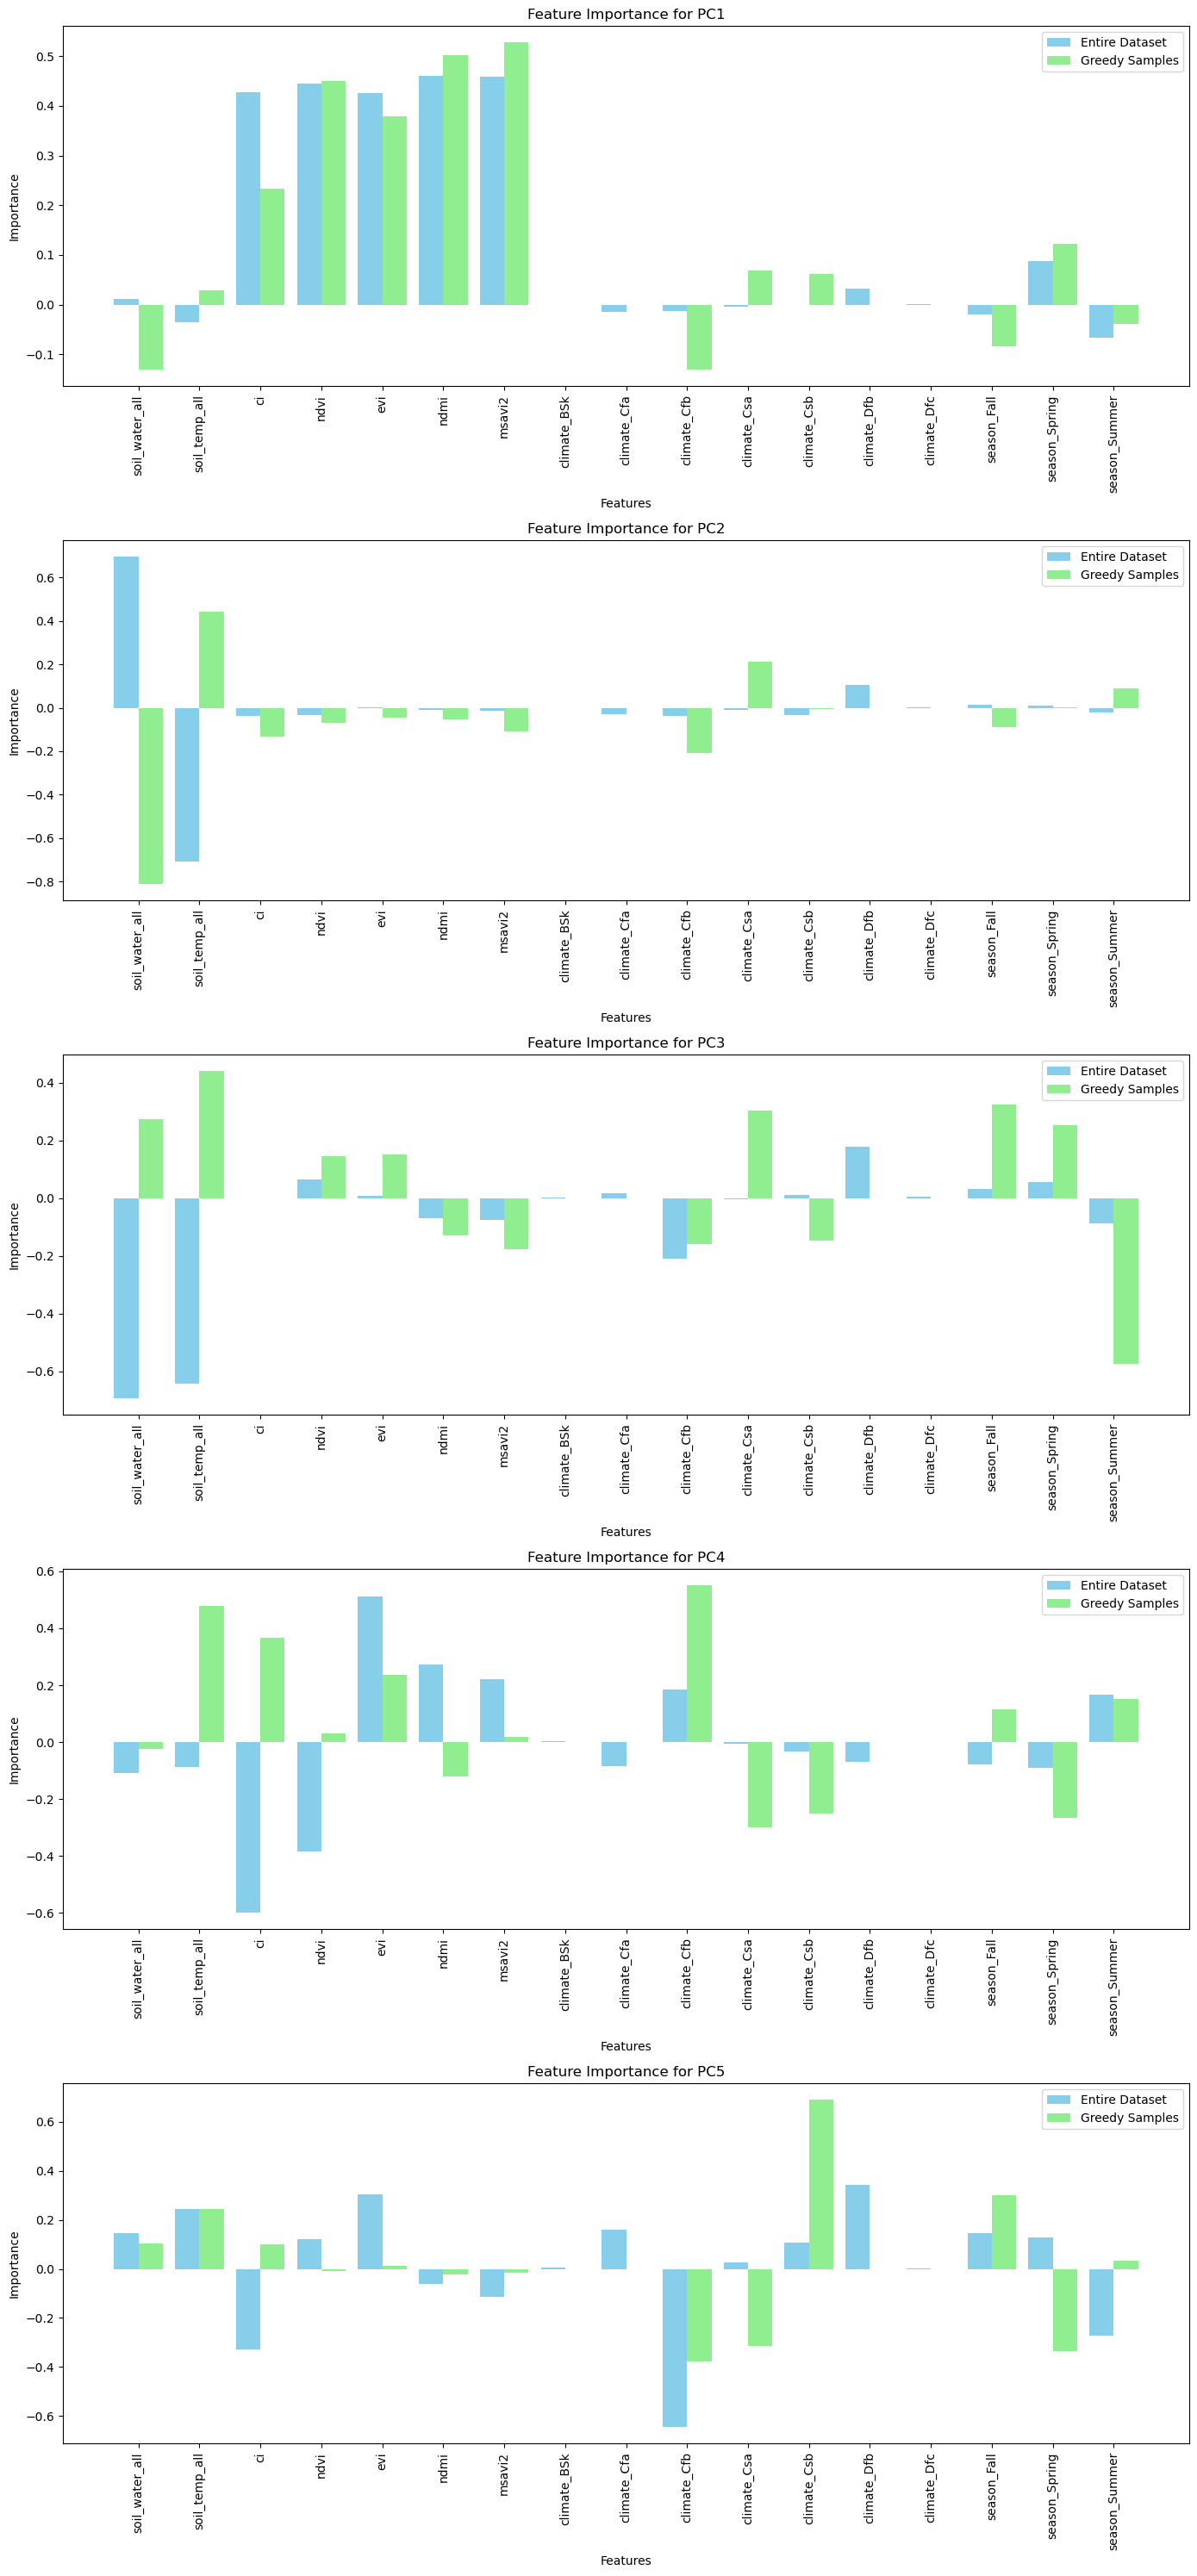

In [38]:
num_components = X_pca.n_components_
fig, axs = plt.subplots(num_components, 1, figsize=(14, num_components * 6))

# Loop to create subplots for each component
for i in range(num_components):
    pc = f'PC{i+1}'
    ax = axs[i] if num_components > 1 else axs  # Handle single subplot case
    width = 0.4
    x = np.arange(len(T.columns))
    
    ax.bar(x - width/2, components_df.loc[pc], width, label='Entire Dataset', color='skyblue')
    ax.bar(x + width/2, greedy_components_df.loc[pc], width, label='Greedy Samples', color='lightgreen')
    ax.set_title(f'Feature Importance for {pc}')
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    ax.set_xticks(x)
    ax.set_xticklabels(T.columns, rotation=90)
    ax.legend()

plt.tight_layout()
plt.show()

Explained Variance Ratio: [0.55838408 0.18592058 0.07429642 0.04243689 0.03896645]
Cumulative Explained Variance: 0.9000044197021883


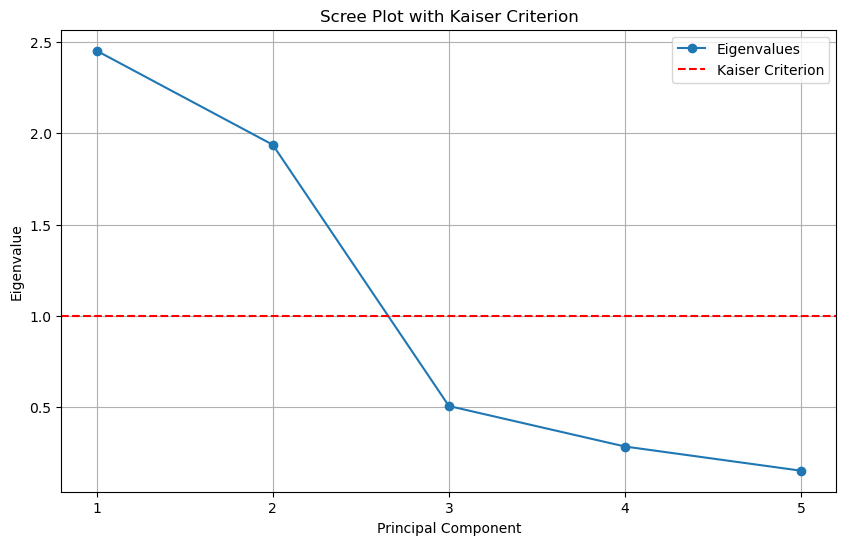

In [44]:
explained_variance = X_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance[-1])



# Eigenvalues
eigenvalues = g_pca.explained_variance_


kaiser_criterion = eigenvalues > 1
num_components = sum(kaiser_criterion)
# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues')
plt.axhline(y=1, color='r', linestyle='--', label='Kaiser Criterion')
#plt.fill_between(range(1, len(eigenvalues) + 1), eigenvalues, where=kaiser_criterion, color='skyblue', alpha=0.5)
plt.title('Scree Plot with Kaiser Criterion')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.legend()
plt.grid()
plt.show()